In [98]:
# general imports
import random
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.utils.data as utils

import matplotlib.pyplot as plt
plt.rcParams["legend.loc"] = "best"
plt.rcParams['figure.facecolor'] = 'white'
%matplotlib inline

In [2]:
# filter python warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
# prepare MNIST data
import torchvision.datasets as datasets

# train data
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_train_images = mnist_trainset.train_data.numpy()[..., np.newaxis]
mnist_train_labels = mnist_trainset.train_labels.numpy()

# test data
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
mnist_test_images = mnist_testset.test_data.numpy()[..., np.newaxis]
mnist_test_labels = mnist_testset.test_labels.numpy()

In [6]:
# The Deep Convolution Random Forest class (for binary classification)
class ConvRF(object):
    def __init__(self, kernel_size=5, stride=2):
        self.kernel_size = kernel_size
        self.stride = stride
        self.kernel_forests = None

    def _convolve_chop(self, images, labels=None, flatten=False):

        batch_size, in_dim, _, num_channels = images.shape

        out_dim = int((in_dim - self.kernel_size) / self.stride) + 1  # calculate output dimensions

        # create matrix to hold the chopped images
        out_images = np.zeros((batch_size, out_dim, out_dim,
                               self.kernel_size, self.kernel_size, num_channels))
        out_labels = None

        curr_y = out_y = 0
        # move kernel vertically across the image
        while curr_y + self.kernel_size <= in_dim:
            curr_x = out_x = 0
            # move kernel horizontally across the image
            while curr_x + self.kernel_size <= in_dim:
                # chop images
                out_images[:, out_x, out_y] = images[:, curr_x:curr_x +
                                                     self.kernel_size, curr_y:curr_y+self.kernel_size, :]
                curr_x += self.stride
                out_x += 1
            curr_y += self.stride
            out_y += 1

        if flatten:
            out_images = out_images.reshape(batch_size, out_dim, out_dim, -1)

        if labels is not None:
            out_labels = np.zeros((batch_size, out_dim, out_dim))
            out_labels[:, ] = labels.reshape(-1, 1, 1)

        return out_images, out_labels

    def convolve_fit(self, images, labels):
        num_channels = images.shape[-1]
        sub_images, sub_labels = self._convolve_chop(images, labels=labels, flatten=True)

        batch_size, out_dim, _, _ = sub_images.shape
        self.kernel_forests = np.zeros((out_dim, out_dim), dtype=np.int).tolist()
        convolved_image = np.zeros((images.shape[0], out_dim, out_dim, 1))
        
        for i in range(out_dim):
            for j in range(out_dim):
                self.kernel_forests[i][j] = RandomForestClassifier()
                self.kernel_forests[i][j].fit(sub_images[:, i, j], sub_labels[:, i, j])
                convolved_image[:, i, j] = self.kernel_forests[i][j].predict_proba(sub_images[:, i, j])[..., 1][..., np.newaxis]
        return convolved_image

    def convolve_predict(self, images):
        if not self.kernel_forests:
            raise Exception("Should fit training data before predicting")

        num_channels = images.shape[-1]
        sub_images, _ = self._convolve_chop(images, flatten=True)

        batch_size, out_dim, _, _ = sub_images.shape
        
        kernel_predictions = np.zeros((images.shape[0], out_dim, out_dim, 1))
        
        for i in range(out_dim):
            for j in range(out_dim):
                kernel_predictions[:, i, j] = self.kernel_forests[i][j].predict_proba(sub_images[:, i, j])[..., 1][..., np.newaxis]
        return kernel_predictions

In [25]:
# define a simple CNN arhcitecture
from torch.autograd import Variable
import torch.nn.functional as F

class SimpleCNNOneFilter(torch.nn.Module):
    
    def __init__(self):
        super(SimpleCNNOneFilter, self).__init__()        
        self.conv1 = torch.nn.Conv2d(1, 1, kernel_size=10, stride=2)
        self.fc1 = torch.nn.Linear(100, 2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 100)
        x = self.fc1(x)
        return(x)

class SimpleCNN32Filter(torch.nn.Module):
    
    def __init__(self):
        super(SimpleCNN32Filter, self).__init__()        
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=10, stride=2) # try 64 too, if possible
        self.fc1 = torch.nn.Linear(100*32, 2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 100*32)
        x = self.fc1(x)
        return(x)

In [16]:
def run_naive_rf(train_images, train_labels, test_images, test_labels, fraction_of_train_samples, class1=3, class2=8):
    num_train_samples_class_1 = int(np.sum(train_labels==class1) * fraction_of_train_samples)
    num_train_samples_class_2 = int(np.sum(train_labels==class2) * fraction_of_train_samples)
    
    # get only train images and labels for class 1 and class 2
    train_images = np.concatenate([train_images[train_labels==class1][:num_train_samples_class_1], train_images[train_labels==class2][:num_train_samples_class_2]])
    train_labels = np.concatenate([np.repeat(0, num_train_samples_class_1), np.repeat(1, num_train_samples_class_2)])

    # get only test images and labels for class 1 and class 2
    test_images = np.concatenate([test_images[test_labels==class1], test_images[test_labels==class2]])
    test_labels = np.concatenate([np.repeat(0, np.sum(test_labels==class1)), np.repeat(1, np.sum(test_labels==class2))])

    # Train
    clf = RandomForestClassifier()
    clf.fit(train_images.reshape(-1, 28*28*1), train_labels)
    # Test
    test_preds = clf.predict(test_images.reshape(-1, 28*28*1))
    return accuracy_score(test_labels, test_preds)

In [7]:
def run_one_layer_deep_conv_rf(train_images, train_labels, test_images, test_labels, fraction_of_train_samples, class1=3, class2=8):
    num_train_samples_class_1 = int(np.sum(train_labels==class1) * fraction_of_train_samples)
    num_train_samples_class_2 = int(np.sum(train_labels==class2) * fraction_of_train_samples)
    
    # get only train images and labels for class 1 and class 2
    train_images = np.concatenate([train_images[train_labels==class1][:num_train_samples_class_1], train_images[train_labels==class2][:num_train_samples_class_2]])
    train_labels = np.concatenate([np.repeat(0, num_train_samples_class_1), np.repeat(1, num_train_samples_class_2)])

    # get only test images and labels for class 1 and class 2
    test_images = np.concatenate([test_images[test_labels==class1], test_images[test_labels==class2]])
    test_labels = np.concatenate([np.repeat(0, np.sum(test_labels==class1)), np.repeat(1, np.sum(test_labels==class2))])
    
    ## Train
    # ConvRF (layer 1)
    conv1 = ConvRF(kernel_size=10, stride=2)
    conv1_map = conv1.convolve_fit(train_images, train_labels)

    # Full RF
    conv1_full_RF = RandomForestClassifier()
    conv1_full_RF.fit(conv1_map.reshape(len(train_images), -1), train_labels)

    ## Test (after ConvRF 1 and Full RF)
    conv1_map_test = conv1.convolve_predict(test_images)
    mnist_test_preds = conv1_full_RF.predict(conv1_map_test.reshape(len(test_images), -1))

    return accuracy_score(test_labels, mnist_test_preds)

In [102]:
def cnn_train_test(cnn_model, x_train, y_train, x_test, y_test):
    # set params
    num_epochs = 25
    learning_rate = 0.001

    # prepare data
    tensor_x = torch.stack([torch.Tensor(i.reshape(1, 28, 28)) for i in x_train]).float() # transform to torch tensors
    tensor_y = torch.stack([torch.Tensor([i]) for i in y_train]).long()

    my_dataset = utils.TensorDataset(tensor_x,tensor_y) # create your datset
    train_loader = utils.DataLoader(my_dataset, batch_size=64, shuffle=True) # create your dataloader

    tensor_x = torch.stack([torch.Tensor(i.reshape(1, 28, 28)) for i in x_test]).float() # transform to torch tensors
    tensor_y = torch.stack([torch.Tensor([i]) for i in y_test]).long()

    my_dataset = utils.TensorDataset(tensor_x,tensor_y) # create your datset
    test_loader = utils.DataLoader(my_dataset, batch_size=64) # create your dataloader

    # define model
    model = cnn_model()

    # loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # train the model
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images
            labels = labels

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels.view(-1))

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


    # test the model
    accuracy = 0
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images
            labels = labels
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.view(-1) == labels.view(-1)).sum()
        accuracy = float(correct) / float(total)
    return accuracy

In [103]:
def run_one_layer_cnn(cnn_model, train_images, train_labels, test_images, test_labels, fraction_of_train_samples, class1=3, class2=8):
    num_train_samples_class_1 = int(np.sum(train_labels==class1) * fraction_of_train_samples)
    num_train_samples_class_2 = int(np.sum(train_labels==class2) * fraction_of_train_samples)
    
    # get only train images and labels for class 1 and class 2
    train_images = np.concatenate([train_images[train_labels==class1][:num_train_samples_class_1], train_images[train_labels==class2][:num_train_samples_class_2]])
    train_labels = np.concatenate([np.repeat(0, num_train_samples_class_1), np.repeat(1, num_train_samples_class_2)])

    # get only test images and labels for class 1 and class 2
    test_images = np.concatenate([test_images[test_labels==class1], test_images[test_labels==class2]])
    test_labels = np.concatenate([np.repeat(0, np.sum(test_labels==class1)), np.repeat(1, np.sum(test_labels==class2))])

    return cnn_train_test(cnn_model, train_images, train_labels, test_images, test_labels)

Label: 0


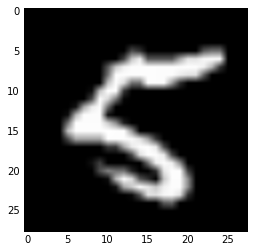

Label: 1


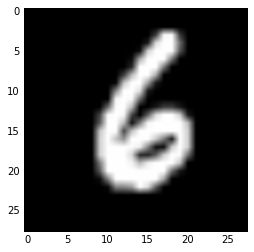

In [12]:
# 5 vs 6 classification

# get only train images and labels for two classes: 1 and 7
mnist_train_images_5_6 = np.concatenate([mnist_train_images[mnist_train_labels==5], mnist_train_images[mnist_train_labels==6]])
mnist_train_labels_5_6 = np.concatenate([np.repeat(0, np.sum(mnist_train_labels==5)), np.repeat(1, np.sum(mnist_train_labels==6))])

# visualize data and labels

# 5 (label 0)
index = 3000
print("Label:", mnist_train_labels_5_6[index])
plt.imshow(mnist_train_images_5_6[index].reshape(28, 28),cmap='gray')
plt.show()

# 6 (label 1)
index = 8000
print("Label:", mnist_train_labels_5_6[index])
plt.imshow(mnist_train_images_5_6[index].reshape(28, 28),cmap='gray')
plt.show()

In [105]:
# accuracy vs num training samples (naive_rf)
naive_rf_acc_vs_n = list()
fraction_of_train_samples_space = np.geomspace(0.01, 1.0, num=10)
for fraction_of_train_samples in fraction_of_train_samples_space:
    best_accuracy = np.mean([run_naive_rf(mnist_train_images, mnist_train_labels, mnist_test_images, mnist_test_labels, fraction_of_train_samples, 5, 6) for _ in range(3)])
    naive_rf_acc_vs_n.append(best_accuracy)
    print("Train Fraction:", str(fraction_of_train_samples))
    print("Accuracy:", str(best_accuracy))

Train Fraction: 0.01
Accuracy: 0.934954954954955
Train Fraction: 0.016681005372000592
Accuracy: 0.9488288288288288
Train Fraction: 0.027825594022071243
Accuracy: 0.9493693693693693
Train Fraction: 0.046415888336127774
Accuracy: 0.9527927927927928
Train Fraction: 0.0774263682681127
Accuracy: 0.9632432432432433
Train Fraction: 0.1291549665014884
Accuracy: 0.969009009009009
Train Fraction: 0.21544346900318834
Accuracy: 0.9733333333333333
Train Fraction: 0.3593813663804626
Accuracy: 0.9772972972972972
Train Fraction: 0.5994842503189409
Accuracy: 0.9818018018018018
Train Fraction: 1.0
Accuracy: 0.9828828828828828


In [106]:
# accuracy vs num training samples (one layer deep_conv_rf)
deep_conv_rf_acc_vs_n = list()
fraction_of_train_samples_space = np.geomspace(0.01, 1.0, num=10)
for fraction_of_train_samples in fraction_of_train_samples_space:
    best_accuracy = np.mean([run_one_layer_deep_conv_rf(mnist_train_images, mnist_train_labels, mnist_test_images, mnist_test_labels, fraction_of_train_samples, 5, 6) for _ in range(3)])
    deep_conv_rf_acc_vs_n.append(best_accuracy)
    print("Train Fraction:", str(fraction_of_train_samples))
    print("Accuracy:", str(best_accuracy))

Train Fraction: 0.01
Accuracy: 0.9371171171171171
Train Fraction: 0.016681005372000592
Accuracy: 0.9407207207207207
Train Fraction: 0.027825594022071243
Accuracy: 0.956036036036036
Train Fraction: 0.046415888336127774
Accuracy: 0.9598198198198199
Train Fraction: 0.0774263682681127
Accuracy: 0.9681081081081081
Train Fraction: 0.1291549665014884
Accuracy: 0.9744144144144143
Train Fraction: 0.21544346900318834
Accuracy: 0.9794594594594596
Train Fraction: 0.3593813663804626
Accuracy: 0.981981981981982
Train Fraction: 0.5994842503189409
Accuracy: 0.9866666666666667
Train Fraction: 1.0
Accuracy: 0.9891891891891892


In [107]:
# accuracy vs num training samples (one layer cnn)
cnn_acc_vs_n = list()
fraction_of_train_samples_space = np.geomspace(0.01, 1.0, num=10)
for fraction_of_train_samples in fraction_of_train_samples_space:
    best_accuracy = np.mean([run_one_layer_cnn(SimpleCNNOneFilter, mnist_train_images, mnist_train_labels, mnist_test_images, mnist_test_labels, fraction_of_train_samples, 5, 6) for _ in range(3)])
    cnn_acc_vs_n.append(best_accuracy)
    print("Train Fraction:", str(fraction_of_train_samples))
    print("Accuracy:", str(best_accuracy))

Train Fraction: 0.01
Accuracy: 0.7036036036036036
Train Fraction: 0.016681005372000592
Accuracy: 0.7358558558558559
Train Fraction: 0.027825594022071243
Accuracy: 0.8524324324324324
Train Fraction: 0.046415888336127774
Accuracy: 0.9466666666666667
Train Fraction: 0.0774263682681127
Accuracy: 0.9425225225225224
Train Fraction: 0.1291549665014884
Accuracy: 0.9517117117117118
Train Fraction: 0.21544346900318834
Accuracy: 0.9789189189189189
Train Fraction: 0.3593813663804626
Accuracy: 0.9792792792792793
Train Fraction: 0.5994842503189409
Accuracy: 0.9866666666666667
Train Fraction: 1.0
Accuracy: 0.9850450450450451


In [104]:
# accuracy vs num training samples (one layer cnn (32 filters))
cnn32_acc_vs_n = list()
fraction_of_train_samples_space = np.geomspace(0.01, 1.0, num=10)
for fraction_of_train_samples in fraction_of_train_samples_space:
    best_accuracy = np.mean([run_one_layer_cnn(SimpleCNN32Filter, mnist_train_images, mnist_train_labels, mnist_test_images, mnist_test_labels, fraction_of_train_samples, 5, 6) for _ in range(3)])
    cnn32_acc_vs_n.append(best_accuracy)
    print("Train Fraction:", str(fraction_of_train_samples))
    print("Accuracy:", str(best_accuracy))

Train Fraction: 0.01
Accuracy: 0.9463063063063063
Train Fraction: 0.016681005372000592
Accuracy: 0.9585585585585585
Train Fraction: 0.027825594022071243
Accuracy: 0.9637837837837838
Train Fraction: 0.046415888336127774
Accuracy: 0.9699099099099099
Train Fraction: 0.0774263682681127
Accuracy: 0.9783783783783783
Train Fraction: 0.1291549665014884
Accuracy: 0.9772972972972974
Train Fraction: 0.21544346900318834
Accuracy: 0.9873873873873874
Train Fraction: 0.3593813663804626
Accuracy: 0.9866666666666667
Train Fraction: 0.5994842503189409
Accuracy: 0.990990990990991
Train Fraction: 1.0
Accuracy: 0.9931531531531531


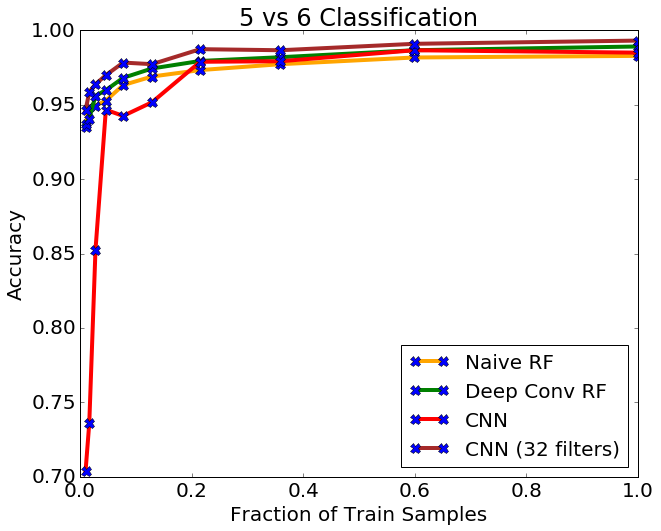

In [110]:
plt.rcParams['figure.figsize'] = 10, 8
plt.rcParams['font.size'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['figure.titlesize'] = 20

fig, ax = plt.subplots() # create a new figure with a default 111 subplot
ax.plot(fraction_of_train_samples_space, naive_rf_acc_vs_n, marker='X', markerfacecolor='blue', markersize=10, color='orange', linewidth=4, label="Naive RF")
ax.plot(fraction_of_train_samples_space, deep_conv_rf_acc_vs_n, marker='X', markerfacecolor='blue', markersize=10, color='green', linewidth=4, label="Deep Conv RF")
ax.plot(fraction_of_train_samples_space, cnn_acc_vs_n, marker='X', markerfacecolor='blue', markersize=10, color='red', linewidth=4, label="CNN")
ax.plot(fraction_of_train_samples_space, cnn32_acc_vs_n, marker='X', markerfacecolor='blue', markersize=10, color='brown', linewidth=4, label="CNN (32 filters)")

ax.set_xlabel('Fraction of Train Samples')
ax.set_xlim(0, 1.0)
ax.set_ylabel('Accuracy')
ax.set_ylim(0.70, 1)
ax.set_title("5 vs 6 Classification")
plt.legend()
plt.show()

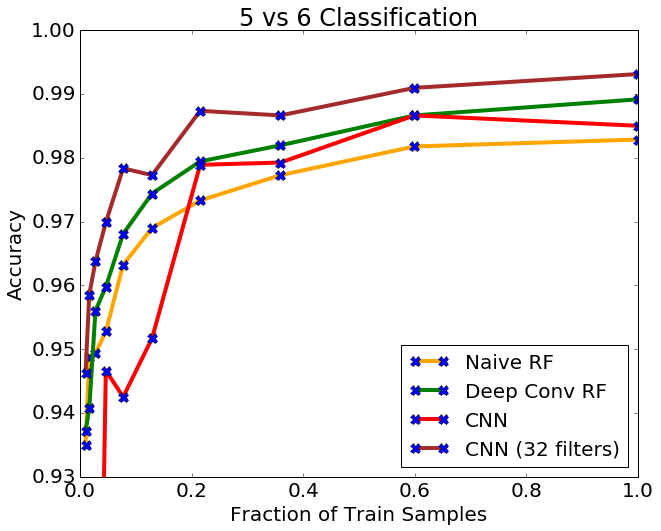

In [109]:
plt.rcParams['figure.figsize'] = 10, 8
plt.rcParams['font.size'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['figure.titlesize'] = 20

fig, ax = plt.subplots() # create a new figure with a default 111 subplot
ax.plot(fraction_of_train_samples_space, naive_rf_acc_vs_n, marker='X', markerfacecolor='blue', markersize=10, color='orange', linewidth=4, label="Naive RF")
ax.plot(fraction_of_train_samples_space, deep_conv_rf_acc_vs_n, marker='X', markerfacecolor='blue', markersize=10, color='green', linewidth=4, label="Deep Conv RF")
ax.plot(fraction_of_train_samples_space, cnn_acc_vs_n, marker='X', markerfacecolor='blue', markersize=10, color='red', linewidth=4, label="CNN")
ax.plot(fraction_of_train_samples_space, cnn32_acc_vs_n, marker='X', markerfacecolor='blue', markersize=10, color='brown', linewidth=4, label="CNN (32 filters)")

ax.set_xlabel('Fraction of Train Samples')
ax.set_xlim(0, 1.0)
ax.set_ylabel('Accuracy')
ax.set_ylim(0.93, 1)
ax.set_title("5 vs 6 Classification")
plt.legend()
plt.show()